In [67]:
import numpy as np
import pandas as pd
from agent_ma import MovingAverageCrossoverAgent
from agent_dummy import DummyAgent
from agent_BollingerBands import BollingerBandsAgent
from agent_macd import MACDAgent
from agent_momentum import MomentumAgent
from agent_mr import MeanReversionAgent
from agent_rsi import RSIAgent
from agent_composite import CompositeAgent
from agent_emav import EMAVAgent
import matplotlib.pyplot as plt
import requests

# 1m Interval

2024-07-23 23:30:51.470151: MAC Hold
2024-07-23 23:30:51.471148: MAC Hold
2024-07-23 23:30:51.472148: MAC Hold
2024-07-23 23:30:51.472148: MAC Hold
2024-07-23 23:30:51.473598: MAC Hold
2024-07-23 23:30:51.475104: MAC Buy at 67566.01
2024-07-23 23:30:51.475104: MAC Hold
2024-07-23 23:30:51.476111: MAC Hold
2024-07-23 23:30:51.477113: MAC Sell at 67532.01
2024-07-23 23:30:51.478113: MAC Hold
2024-07-23 23:30:51.478113: MAC Hold
2024-07-23 23:30:51.479113: MAC Hold
2024-07-23 23:30:51.479113: MAC Hold
2024-07-23 23:30:51.480411: MAC Hold
2024-07-23 23:30:51.481418: MAC Hold
2024-07-23 23:30:51.482416: MAC Buy at 67603.99
2024-07-23 23:30:51.482416: MAC Hold
2024-07-23 23:30:51.483878: MAC Hold
2024-07-23 23:30:51.483878: MAC Hold
2024-07-23 23:30:51.484887: MAC Hold
2024-07-23 23:30:51.485885: MAC Hold
2024-07-23 23:30:51.485885: MAC Hold
2024-07-23 23:30:51.487154: MAC Hold
2024-07-23 23:30:51.488647: MAC Hold
2024-07-23 23:30:51.489150: MAC Hold
2024-07-23 23:30:51.489150: MAC Hold
2024

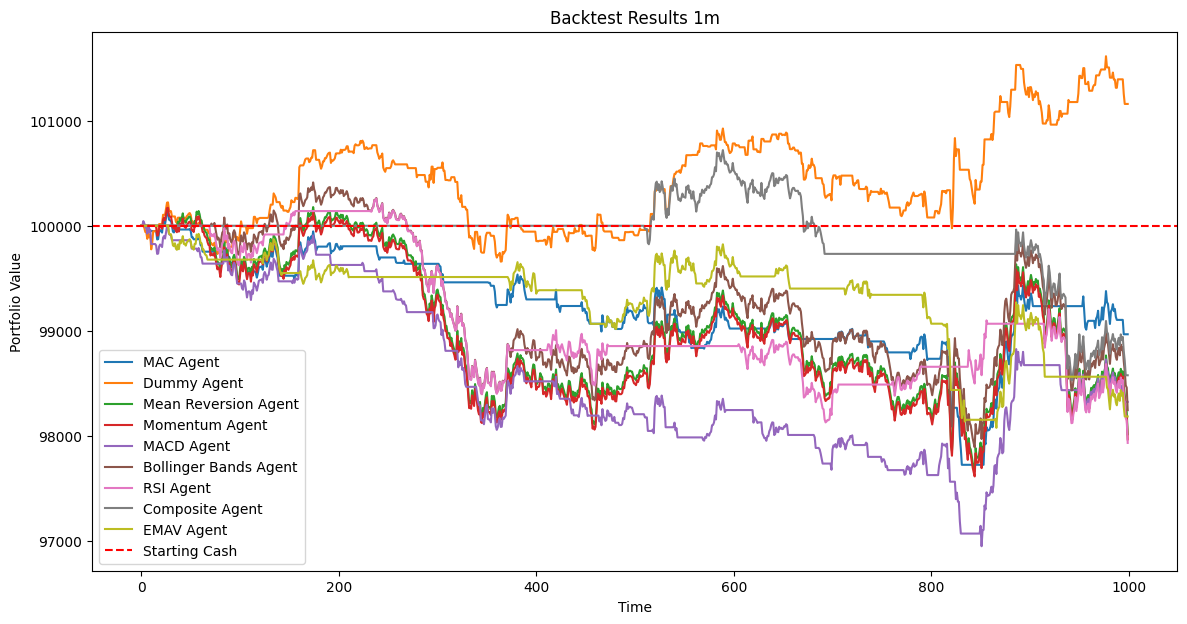

Moving Average Crossover Agent Metrics: {'Total Return': -0.010323447201023227, 'Sharpe Ratio': -116.92475419826295, 'Max Drawdown': -0.024053324300453708}
Dummy Agent Metrics: {'Total Return': 0.011591075153214333, 'Sharpe Ratio': -104.64232372325075, 'Max Drawdown': -0.011418256679687776}
Mean Reversion Agent Metrics: {'Total Return': -0.01984137318733352, 'Sharpe Ratio': -76.1816936314376, 'Max Drawdown': -0.025096011816839056}
Momentum Agent Metrics: {'Total Return': -0.0203255567683329, 'Sharpe Ratio': -75.87076733275195, 'Max Drawdown': -0.02551027790549314}
MACD Agent Metrics: {'Total Return': -0.016754869466189704, 'Sharpe Ratio': -104.10425897216619, 'Max Drawdown': -0.030920261881825402}
Bollinger Bands Agent Metrics: {'Total Return': -0.017544567419452504, 'Sharpe Ratio': -76.61764767669436, 'Max Drawdown': -0.02509601181683902}
RSI Agent Metrics: {'Total Return': -0.020660475860600564, 'Sharpe Ratio': -103.81752699660066, 'Max Drawdown': -0.023186056325100547}
Composite Age

In [68]:
def fetch_historical_data(symbol, interval, limit=1000):
    """
    interval:
    1m, 3m, 5m, 15m, 30m
    1h, 2h, 4h, 6h, 8h, 12h,
    1d, 3d, 1w, 1M
    """
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    return df

def backtest(agent, historical_data):
    cash_start = agent.cash
    portfolio_values = []
    for i in range(len(historical_data)):
        agent.trade(historical_data.iloc[:i+1])
        current_price = historical_data['Close'].iloc[i]
        portfolio_value = agent.get_portfolio_value(current_price)
        portfolio_values.append(portfolio_value)
    return portfolio_values, cash_start

def calculate_metrics(portfolio_values, cash_start):
    # Total Return
    total_return = (portfolio_values[-1] - cash_start) / cash_start
    
    # Daily Returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Sharpe Ratio
    risk_free_rate = 0.0543  # As of July 2024, the yield on a 3-month U.S. Treasury bill, which is commonly used as a proxy for the risk-free rate, is approximately 5.43%​ (U.S. Department of the Treasury)​​ (YCharts)​.
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns)
    
    # Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_returns) / cumulative_returns
    max_drawdown = drawdowns.min()
    
    return {
        "Total Return": total_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

if __name__ == "__main__":
    # Fetch historical data
    historical_data = fetch_historical_data("BTCUSDT", "1m")
    
    # Initialize agents
    mac_agent = MovingAverageCrossoverAgent()
    dummy_agent = DummyAgent()
    mean_reversion_agent = MeanReversionAgent()
    momentum_agent = MomentumAgent()
    macd_agent = MACDAgent()
    bollinger_bands_agent = BollingerBandsAgent()
    rsi_agent = RSIAgent()
    composite_agent = CompositeAgent()
    emav_agent = EMAVAgent()
    
    # Backtest agents
    mac_values, mac_start_cash = backtest(mac_agent, historical_data)
    dummy_values, dummy_start_cash = backtest(dummy_agent, historical_data)
    mean_reversion_values, mean_reversion_start_cash = backtest(mean_reversion_agent, historical_data)
    momentum_values, momentum_start_cash = backtest(momentum_agent, historical_data)
    macd_values, macd_start_cash = backtest(macd_agent, historical_data)
    bollinger_bands_values, bollinger_bands_start_cash = backtest(bollinger_bands_agent, historical_data)
    rsi_values, rsi_start_cash = backtest(rsi_agent, historical_data)
    composite_values, composite_start_cash = backtest(composite_agent, historical_data)
    emav_values, emav_start_cash = backtest(emav_agent, historical_data)

    # Calculate metrics for each agent
    mac_metrics = calculate_metrics(mac_values, mac_start_cash)
    dummy_metrics = calculate_metrics(dummy_values, dummy_start_cash)
    mean_reversion_metrics = calculate_metrics(mean_reversion_values, mean_reversion_start_cash)
    momentum_metrics = calculate_metrics(momentum_values, momentum_start_cash)
    macd_metrics = calculate_metrics(macd_values, macd_start_cash)
    bollinger_bands_metrics = calculate_metrics(bollinger_bands_values, bollinger_bands_start_cash)
    rsi_metrics = calculate_metrics(rsi_values, rsi_start_cash)
    composite_metrics = calculate_metrics(composite_values, rsi_start_cash)
    emav_metrics = calculate_metrics(emav_values, emav_start_cash)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(mac_values, label="MAC Agent")
    plt.plot(dummy_values, label="Dummy Agent")
    plt.plot(mean_reversion_values, label="Mean Reversion Agent")
    plt.plot(momentum_values, label="Momentum Agent")
    plt.plot(macd_values, label="MACD Agent")
    plt.plot(bollinger_bands_values, label="Bollinger Bands Agent")
    plt.plot(rsi_values, label="RSI Agent")
    plt.plot(composite_values, label="Composite Agent")
    plt.plot(emav_values, label="EMAV Agent")
    plt.axhline(y=mac_start_cash, color='r', linestyle='--', label="Starting Cash")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.title("Backtest Results 1m")
    plt.legend()
    plt.show()

    # Print metrics
    print("Moving Average Crossover Agent Metrics:", mac_metrics)
    print("Dummy Agent Metrics:", dummy_metrics)
    print("Mean Reversion Agent Metrics:", mean_reversion_metrics)
    print("Momentum Agent Metrics:", momentum_metrics)
    print("MACD Agent Metrics:", macd_metrics)
    print("Bollinger Bands Agent Metrics:", bollinger_bands_metrics)
    print("RSI Agent Metrics:", rsi_metrics)
    print("Composite Agent Metrics:", composite_metrics)
    print("EMAV Agent Metrics:", emav_metrics)


# 1h Interval

2024-07-23 23:30:59.429915: MAC Hold
2024-07-23 23:30:59.430958: MAC Hold
2024-07-23 23:30:59.430958: MAC Hold
2024-07-23 23:30:59.431958: MAC Hold
2024-07-23 23:30:59.432957: MAC Hold
2024-07-23 23:30:59.433762: MAC Buy at 67281.64
2024-07-23 23:30:59.434775: MAC Hold
2024-07-23 23:30:59.435819: MAC Hold
2024-07-23 23:30:59.436828: MAC Hold
2024-07-23 23:30:59.436828: MAC Hold
2024-07-23 23:30:59.437825: MAC Hold
2024-07-23 23:30:59.439019: MAC Hold
2024-07-23 23:30:59.439019: MAC Hold
2024-07-23 23:30:59.440108: MAC Hold
2024-07-23 23:30:59.440108: MAC Hold
2024-07-23 23:30:59.441482: MAC Hold
2024-07-23 23:30:59.442492: MAC Hold
2024-07-23 23:30:59.442492: MAC Hold
2024-07-23 23:30:59.443492: MAC Hold
2024-07-23 23:30:59.443492: MAC Hold
2024-07-23 23:30:59.444970: MAC Hold
2024-07-23 23:30:59.445474: MAC Sell at 68345.82
2024-07-23 23:30:59.446481: MAC Hold
2024-07-23 23:30:59.446481: MAC Hold
2024-07-23 23:30:59.447830: MAC Hold
2024-07-23 23:30:59.448919: MAC Hold
2024-07-23 23:3

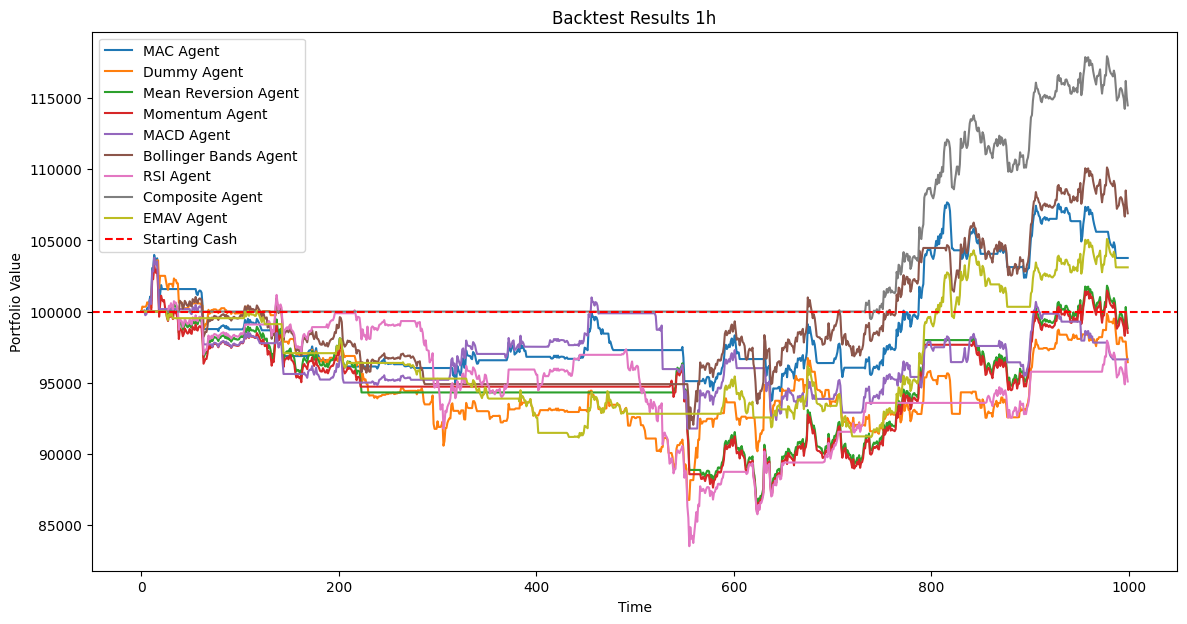

Moving Average Crossover Agent Metrics: {'Total Return': 0.03766180406577448, 'Sharpe Ratio': -15.904360309921518, 'Max Drawdown': -0.0986866988669112}
Dummy Agent Metrics: {'Total Return': -0.03557577252986361, 'Sharpe Ratio': -13.90111131722, 'Max Drawdown': -0.16253461104116504}
Mean Reversion Agent Metrics: {'Total Return': -0.01163783155014753, 'Sharpe Ratio': -14.168544597089948, 'Max Drawdown': -0.1424340670563131}
Momentum Agent Metrics: {'Total Return': -0.01495362390801456, 'Sharpe Ratio': -13.544327112533706, 'Max Drawdown': -0.16773028877424084}
MACD Agent Metrics: {'Total Return': -0.03360167631397766, 'Sharpe Ratio': -15.553515265238577, 'Max Drawdown': -0.11559307441804655}
Bollinger Bands Agent Metrics: {'Total Return': 0.06905936865080352, 'Sharpe Ratio': -13.75773013242122, 'Max Drawdown': -0.09138419648972074}
RSI Agent Metrics: {'Total Return': -0.04914140864691231, 'Sharpe Ratio': -13.786037026575421, 'Max Drawdown': -0.17459004153948157}
Composite Agent Metrics: {

In [69]:
def fetch_historical_data(symbol, interval, limit=1000):
    """
    interval:
    1m, 3m, 5m, 15m, 30m
    1h, 2h, 4h, 6h, 8h, 12h,
    1d, 3d, 1w, 1M
    """
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    return df

def backtest(agent, historical_data):
    cash_start = agent.cash
    portfolio_values = []
    for i in range(len(historical_data)):
        agent.trade(historical_data.iloc[:i+1])
        current_price = historical_data['Close'].iloc[i]
        portfolio_value = agent.get_portfolio_value(current_price)
        portfolio_values.append(portfolio_value)
    return portfolio_values, cash_start

def calculate_metrics(portfolio_values, cash_start):
    # Total Return
    total_return = (portfolio_values[-1] - cash_start) / cash_start
    
    # Daily Returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Sharpe Ratio
    risk_free_rate = 0.0543  # As of July 2024, the yield on a 3-month U.S. Treasury bill, which is commonly used as a proxy for the risk-free rate, is approximately 5.43%​ (U.S. Department of the Treasury)​​ (YCharts)​.
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns)
    
    # Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_returns) / cumulative_returns
    max_drawdown = drawdowns.min()
    
    return {
        "Total Return": total_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

if __name__ == "__main__":
    # Fetch historical data
    historical_data = fetch_historical_data("BTCUSDT", "1h")
    
    # Initialize agents
    mac_agent = MovingAverageCrossoverAgent()
    dummy_agent = DummyAgent()
    mean_reversion_agent = MeanReversionAgent()
    momentum_agent = MomentumAgent()
    macd_agent = MACDAgent()
    bollinger_bands_agent = BollingerBandsAgent()
    rsi_agent = RSIAgent()
    composite_agent = CompositeAgent()
    emav_agent = EMAVAgent()
    
    # Backtest agents
    mac_values, mac_start_cash = backtest(mac_agent, historical_data)
    dummy_values, dummy_start_cash = backtest(dummy_agent, historical_data)
    mean_reversion_values, mean_reversion_start_cash = backtest(mean_reversion_agent, historical_data)
    momentum_values, momentum_start_cash = backtest(momentum_agent, historical_data)
    macd_values, macd_start_cash = backtest(macd_agent, historical_data)
    bollinger_bands_values, bollinger_bands_start_cash = backtest(bollinger_bands_agent, historical_data)
    rsi_values, rsi_start_cash = backtest(rsi_agent, historical_data)
    composite_values, composite_start_cash = backtest(composite_agent, historical_data)
    emav_values, emav_start_cash = backtest(emav_agent, historical_data)

    # Calculate metrics for each agent
    mac_metrics = calculate_metrics(mac_values, mac_start_cash)
    dummy_metrics = calculate_metrics(dummy_values, dummy_start_cash)
    mean_reversion_metrics = calculate_metrics(mean_reversion_values, mean_reversion_start_cash)
    momentum_metrics = calculate_metrics(momentum_values, momentum_start_cash)
    macd_metrics = calculate_metrics(macd_values, macd_start_cash)
    bollinger_bands_metrics = calculate_metrics(bollinger_bands_values, bollinger_bands_start_cash)
    rsi_metrics = calculate_metrics(rsi_values, rsi_start_cash)
    composite_metrics = calculate_metrics(composite_values, rsi_start_cash)
    emav_metrics = calculate_metrics(emav_values, emav_start_cash)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(mac_values, label="MAC Agent")
    plt.plot(dummy_values, label="Dummy Agent")
    plt.plot(mean_reversion_values, label="Mean Reversion Agent")
    plt.plot(momentum_values, label="Momentum Agent")
    plt.plot(macd_values, label="MACD Agent")
    plt.plot(bollinger_bands_values, label="Bollinger Bands Agent")
    plt.plot(rsi_values, label="RSI Agent")
    plt.plot(composite_values, label="Composite Agent")
    plt.plot(emav_values, label="EMAV Agent")
    plt.axhline(y=mac_start_cash, color='r', linestyle='--', label="Starting Cash")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.title("Backtest Results 1h")
    plt.legend()
    plt.show()

    # Print metrics
    print("Moving Average Crossover Agent Metrics:", mac_metrics)
    print("Dummy Agent Metrics:", dummy_metrics)
    print("Mean Reversion Agent Metrics:", mean_reversion_metrics)
    print("Momentum Agent Metrics:", momentum_metrics)
    print("MACD Agent Metrics:", macd_metrics)
    print("Bollinger Bands Agent Metrics:", bollinger_bands_metrics)
    print("RSI Agent Metrics:", rsi_metrics)
    print("Composite Agent Metrics:", composite_metrics)
    print("EMAV Agent Metrics:", emav_metrics)


# 4h Interval

2024-07-23 23:31:08.127586: MAC Hold
2024-07-23 23:31:08.128640: MAC Hold
2024-07-23 23:31:08.130077: MAC Hold
2024-07-23 23:31:08.131082: MAC Hold
2024-07-23 23:31:08.132089: MAC Hold
2024-07-23 23:31:08.133799: MAC Buy at 46060.74
2024-07-23 23:31:08.134992: MAC Hold
2024-07-23 23:31:08.136141: MAC Hold
2024-07-23 23:31:08.137169: MAC Hold
2024-07-23 23:31:08.138202: MAC Hold
2024-07-23 23:31:08.139213: MAC Hold
2024-07-23 23:31:08.139213: MAC Hold
2024-07-23 23:31:08.140227: MAC Hold
2024-07-23 23:31:08.141224: MAC Hold
2024-07-23 23:31:08.142226: MAC Hold
2024-07-23 23:31:08.143275: MAC Hold
2024-07-23 23:31:08.144663: MAC Hold
2024-07-23 23:31:08.145667: MAC Hold
2024-07-23 23:31:08.145667: MAC Hold
2024-07-23 23:31:08.147568: MAC Hold
2024-07-23 23:31:08.147568: MAC Hold
2024-07-23 23:31:08.148597: MAC Hold
2024-07-23 23:31:08.149604: MAC Hold
2024-07-23 23:31:08.150604: MAC Hold
2024-07-23 23:31:08.150604: MAC Hold
2024-07-23 23:31:08.152098: MAC Hold
2024-07-23 23:31:08.153229:

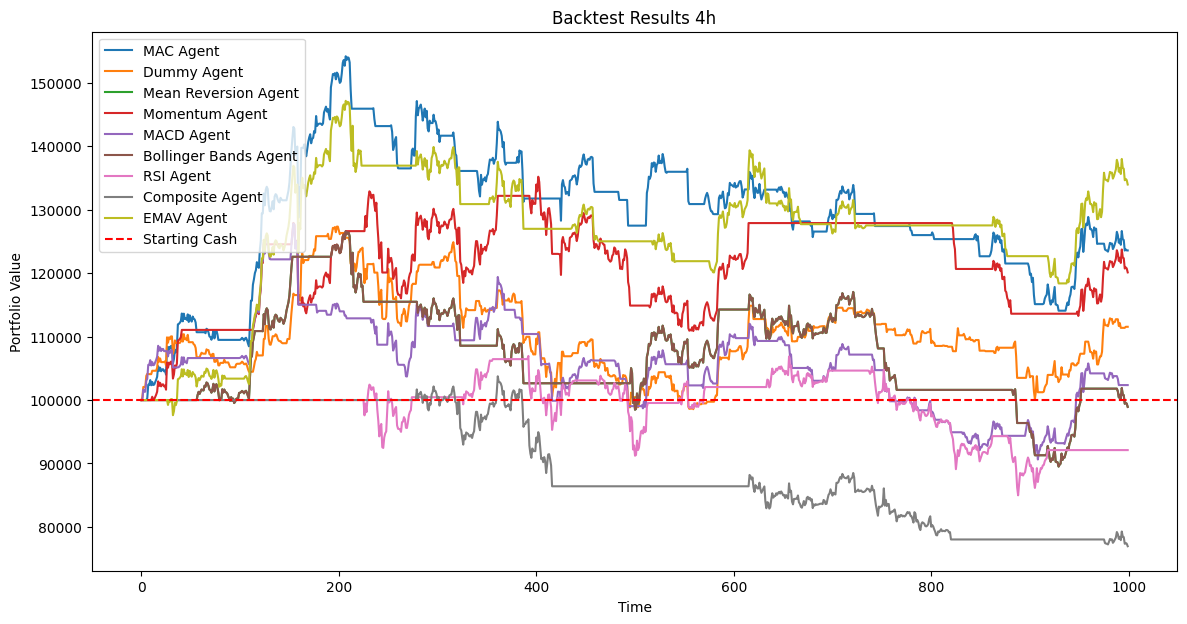

Moving Average Crossover Agent Metrics: {'Total Return': 0.23579759489325153, 'Sharpe Ratio': -6.5450391298512764, 'Max Drawdown': -0.2601236368057534}
Dummy Agent Metrics: {'Total Return': 0.11546076295809646, 'Sharpe Ratio': -6.750594846163117, 'Max Drawdown': -0.22603591825728483}
Mean Reversion Agent Metrics: {'Total Return': -0.010810330304247764, 'Sharpe Ratio': -7.4836843431501245, 'Max Drawdown': -0.2929780626949392}
Momentum Agent Metrics: {'Total Return': 0.20120162384484488, 'Sharpe Ratio': -6.589135040156854, 'Max Drawdown': -0.17990825161215196}
MACD Agent Metrics: {'Total Return': 0.02357253996876592, 'Sharpe Ratio': -6.991235224580431, 'Max Drawdown': -0.2909591935393025}
Bollinger Bands Agent Metrics: {'Total Return': -0.010810330304247764, 'Sharpe Ratio': -7.4836843431501245, 'Max Drawdown': -0.2929780626949392}
RSI Agent Metrics: {'Total Return': -0.07888541934406967, 'Sharpe Ratio': -7.287363833811235, 'Max Drawdown': -0.2053549732871819}
Composite Agent Metrics: {'T

In [70]:
def fetch_historical_data(symbol, interval, limit=1000):
    """
    interval:
    1m, 3m, 5m, 15m, 30m
    1h, 2h, 4h, 6h, 8h, 12h,
    1d, 3d, 1w, 1M
    """
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    return df

def backtest(agent, historical_data):
    cash_start = agent.cash
    portfolio_values = []
    for i in range(len(historical_data)):
        agent.trade(historical_data.iloc[:i+1])
        current_price = historical_data['Close'].iloc[i]
        portfolio_value = agent.get_portfolio_value(current_price)
        portfolio_values.append(portfolio_value)
    return portfolio_values, cash_start

def calculate_metrics(portfolio_values, cash_start):
    # Total Return
    total_return = (portfolio_values[-1] - cash_start) / cash_start
    
    # Daily Returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Sharpe Ratio
    risk_free_rate = 0.0543  # As of July 2024, the yield on a 3-month U.S. Treasury bill, which is commonly used as a proxy for the risk-free rate, is approximately 5.43%​ (U.S. Department of the Treasury)​​ (YCharts)​.
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns)
    
    # Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_returns) / cumulative_returns
    max_drawdown = drawdowns.min()
    
    return {
        "Total Return": total_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

if __name__ == "__main__":
    # Fetch historical data
    historical_data = fetch_historical_data("BTCUSDT", "4h")
    
    # Initialize agents
    mac_agent = MovingAverageCrossoverAgent()
    dummy_agent = DummyAgent()
    mean_reversion_agent = MeanReversionAgent()
    momentum_agent = MomentumAgent()
    macd_agent = MACDAgent()
    bollinger_bands_agent = BollingerBandsAgent()
    rsi_agent = RSIAgent()
    composite_agent = CompositeAgent()
    emav_agent = EMAVAgent()
    
    # Backtest agents
    mac_values, mac_start_cash = backtest(mac_agent, historical_data)
    dummy_values, dummy_start_cash = backtest(dummy_agent, historical_data)
    mean_reversion_values, mean_reversion_start_cash = backtest(mean_reversion_agent, historical_data)
    momentum_values, momentum_start_cash = backtest(momentum_agent, historical_data)
    macd_values, macd_start_cash = backtest(macd_agent, historical_data)
    bollinger_bands_values, bollinger_bands_start_cash = backtest(bollinger_bands_agent, historical_data)
    rsi_values, rsi_start_cash = backtest(rsi_agent, historical_data)
    composite_values, composite_start_cash = backtest(composite_agent, historical_data)
    emav_values, emav_start_cash = backtest(emav_agent, historical_data)

    # Calculate metrics for each agent
    mac_metrics = calculate_metrics(mac_values, mac_start_cash)
    dummy_metrics = calculate_metrics(dummy_values, dummy_start_cash)
    mean_reversion_metrics = calculate_metrics(mean_reversion_values, mean_reversion_start_cash)
    momentum_metrics = calculate_metrics(momentum_values, momentum_start_cash)
    macd_metrics = calculate_metrics(macd_values, macd_start_cash)
    bollinger_bands_metrics = calculate_metrics(bollinger_bands_values, bollinger_bands_start_cash)
    rsi_metrics = calculate_metrics(rsi_values, rsi_start_cash)
    composite_metrics = calculate_metrics(composite_values, rsi_start_cash)
    emav_metrics = calculate_metrics(emav_values, emav_start_cash)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(mac_values, label="MAC Agent")
    plt.plot(dummy_values, label="Dummy Agent")
    plt.plot(mean_reversion_values, label="Mean Reversion Agent")
    plt.plot(momentum_values, label="Momentum Agent")
    plt.plot(macd_values, label="MACD Agent")
    plt.plot(bollinger_bands_values, label="Bollinger Bands Agent")
    plt.plot(rsi_values, label="RSI Agent")
    plt.plot(composite_values, label="Composite Agent")
    plt.plot(emav_values, label="EMAV Agent")
    plt.axhline(y=mac_start_cash, color='r', linestyle='--', label="Starting Cash")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.title("Backtest Results 4h")
    plt.legend()
    plt.show()

    # Print metrics
    print("Moving Average Crossover Agent Metrics:", mac_metrics)
    print("Dummy Agent Metrics:", dummy_metrics)
    print("Mean Reversion Agent Metrics:", mean_reversion_metrics)
    print("Momentum Agent Metrics:", momentum_metrics)
    print("MACD Agent Metrics:", macd_metrics)
    print("Bollinger Bands Agent Metrics:", bollinger_bands_metrics)
    print("RSI Agent Metrics:", rsi_metrics)
    print("Composite Agent Metrics:", composite_metrics)
    print("EMAV Agent Metrics:", emav_metrics)


# 1d Interval

2024-07-23 23:31:17.008936: MAC Hold
2024-07-23 23:31:17.010161: MAC Hold
2024-07-23 23:31:17.011684: MAC Hold
2024-07-23 23:31:17.012694: MAC Hold
2024-07-23 23:31:17.013702: MAC Hold
2024-07-23 23:31:17.014702: MAC Buy at 63219.99
2024-07-23 23:31:17.015736: MAC Hold
2024-07-23 23:31:17.017758: MAC Hold
2024-07-23 23:31:17.017758: MAC Hold
2024-07-23 23:31:17.019057: MAC Hold
2024-07-23 23:31:17.020069: MAC Hold
2024-07-23 23:31:17.021539: MAC Hold
2024-07-23 23:31:17.022549: MAC Hold
2024-07-23 23:31:17.022549: MAC Hold
2024-07-23 23:31:17.023903: MAC Hold
2024-07-23 23:31:17.024994: MAC Hold
2024-07-23 23:31:17.026007: MAC Hold
2024-07-23 23:31:17.026007: MAC Hold
2024-07-23 23:31:17.027007: MAC Hold
2024-07-23 23:31:17.028008: MAC Hold
2024-07-23 23:31:17.029008: MAC Sell at 60344.87
2024-07-23 23:31:17.030006: MAC Hold
2024-07-23 23:31:17.030006: MAC Hold
2024-07-23 23:31:17.031007: MAC Hold
2024-07-23 23:31:17.032007: MAC Hold
2024-07-23 23:31:17.033009: MAC Hold
2024-07-23 23:3

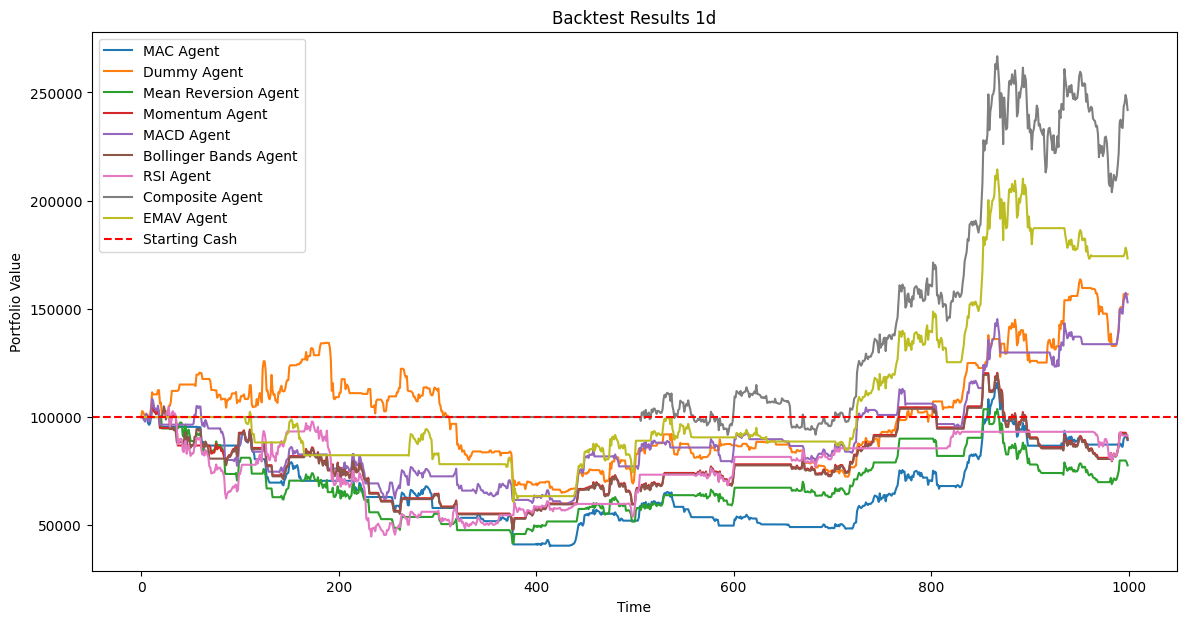

Moving Average Crossover Agent Metrics: {'Total Return': -0.10672546604705684, 'Sharpe Ratio': -2.8312433293670027, 'Max Drawdown': -0.6227284794920499}
Dummy Agent Metrics: {'Total Return': 0.5674725830624925, 'Sharpe Ratio': -2.6117105477471974, 'Max Drawdown': -0.5235331306264829}
Mean Reversion Agent Metrics: {'Total Return': -0.2233221496925944, 'Sharpe Ratio': -2.747571507860799, 'Max Drawdown': -0.5864462391475741}
Momentum Agent Metrics: {'Total Return': -0.0984954666081832, 'Sharpe Ratio': -2.758309902085046, 'Max Drawdown': -0.5480663137311557}
MACD Agent Metrics: {'Total Return': 0.5298723366876468, 'Sharpe Ratio': -2.848023532839822, 'Max Drawdown': -0.4490255560047389}
Bollinger Bands Agent Metrics: {'Total Return': -0.10441351613631239, 'Sharpe Ratio': -2.716093691065422, 'Max Drawdown': -0.5434575919806571}
RSI Agent Metrics: {'Total Return': -0.08523693317727797, 'Sharpe Ratio': -2.503668339123582, 'Max Drawdown': -0.5727331428880962}
Composite Agent Metrics: {'Total Re

In [71]:
def fetch_historical_data(symbol, interval, limit=1000):
    """
    interval:
    1m, 3m, 5m, 15m, 30m
    1h, 2h, 4h, 6h, 8h, 12h,
    1d, 3d, 1w, 1M
    """
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    return df

def backtest(agent, historical_data):
    cash_start = agent.cash
    portfolio_values = []
    for i in range(len(historical_data)):
        agent.trade(historical_data.iloc[:i+1])
        current_price = historical_data['Close'].iloc[i]
        portfolio_value = agent.get_portfolio_value(current_price)
        portfolio_values.append(portfolio_value)
    return portfolio_values, cash_start

def calculate_metrics(portfolio_values, cash_start):
    # Total Return
    total_return = (portfolio_values[-1] - cash_start) / cash_start
    
    # Daily Returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Sharpe Ratio
    risk_free_rate = 0.0543  # As of July 2024, the yield on a 3-month U.S. Treasury bill, which is commonly used as a proxy for the risk-free rate, is approximately 5.43%​ (U.S. Department of the Treasury)​​ (YCharts)​.
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns)
    
    # Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - cumulative_returns) / cumulative_returns
    max_drawdown = drawdowns.min()
    
    return {
        "Total Return": total_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

if __name__ == "__main__":
    # Fetch historical data
    historical_data = fetch_historical_data("BTCUSDT", "1d")
    
    # Initialize agents
    mac_agent = MovingAverageCrossoverAgent()
    dummy_agent = DummyAgent()
    mean_reversion_agent = MeanReversionAgent()
    momentum_agent = MomentumAgent()
    macd_agent = MACDAgent()
    bollinger_bands_agent = BollingerBandsAgent()
    rsi_agent = RSIAgent()
    composite_agent = CompositeAgent()
    emav_agent = EMAVAgent()
    
    # Backtest agents
    mac_values, mac_start_cash = backtest(mac_agent, historical_data)
    dummy_values, dummy_start_cash = backtest(dummy_agent, historical_data)
    mean_reversion_values, mean_reversion_start_cash = backtest(mean_reversion_agent, historical_data)
    momentum_values, momentum_start_cash = backtest(momentum_agent, historical_data)
    macd_values, macd_start_cash = backtest(macd_agent, historical_data)
    bollinger_bands_values, bollinger_bands_start_cash = backtest(bollinger_bands_agent, historical_data)
    rsi_values, rsi_start_cash = backtest(rsi_agent, historical_data)
    composite_values, composite_start_cash = backtest(composite_agent, historical_data)
    emav_values, emav_start_cash = backtest(emav_agent, historical_data)

    # Calculate metrics for each agent
    mac_metrics = calculate_metrics(mac_values, mac_start_cash)
    dummy_metrics = calculate_metrics(dummy_values, dummy_start_cash)
    mean_reversion_metrics = calculate_metrics(mean_reversion_values, mean_reversion_start_cash)
    momentum_metrics = calculate_metrics(momentum_values, momentum_start_cash)
    macd_metrics = calculate_metrics(macd_values, macd_start_cash)
    bollinger_bands_metrics = calculate_metrics(bollinger_bands_values, bollinger_bands_start_cash)
    rsi_metrics = calculate_metrics(rsi_values, rsi_start_cash)
    composite_metrics = calculate_metrics(composite_values, rsi_start_cash)
    emav_metrics = calculate_metrics(emav_values, emav_start_cash)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(mac_values, label="MAC Agent")
    plt.plot(dummy_values, label="Dummy Agent")
    plt.plot(mean_reversion_values, label="Mean Reversion Agent")
    plt.plot(momentum_values, label="Momentum Agent")
    plt.plot(macd_values, label="MACD Agent")
    plt.plot(bollinger_bands_values, label="Bollinger Bands Agent")
    plt.plot(rsi_values, label="RSI Agent")
    plt.plot(composite_values, label="Composite Agent")
    plt.plot(emav_values, label="EMAV Agent")
    plt.axhline(y=mac_start_cash, color='r', linestyle='--', label="Starting Cash")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.title("Backtest Results 1d")
    plt.legend()
    plt.show()

    # Print metrics
    print("Moving Average Crossover Agent Metrics:", mac_metrics)
    print("Dummy Agent Metrics:", dummy_metrics)
    print("Mean Reversion Agent Metrics:", mean_reversion_metrics)
    print("Momentum Agent Metrics:", momentum_metrics)
    print("MACD Agent Metrics:", macd_metrics)
    print("Bollinger Bands Agent Metrics:", bollinger_bands_metrics)
    print("RSI Agent Metrics:", rsi_metrics)
    print("Composite Agent Metrics:", composite_metrics)
    print("EMAV Agent Metrics:", emav_metrics)


In [72]:
def fetch_historical_data(symbol, interval, limit=1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df


fetch_historical_data("BTCUSDT", "1d")

,open,high,low,close,volume
timestamp,,,,,
2021-10-28,58413.44,62499.00,57820.00,60575.89,61056.35301
2021-10-29,60575.90,62980.00,60174.81,62253.71,43973.90414
2021-10-30,62253.70,62359.25,60673.00,61859.19,31478.12566
2021-10-31,61859.19,62405.30,59945.36,61299.80,39267.63794
2021-11-01,61299.81,62437.74,59405.00,60911.11,44687.66672
...,...,...,...,...,...
2024-07-19,63987.92,67386.00,63300.67,66660.00,35634.72739
2024-07-20,66660.01,67598.00,66222.46,67139.96,14386.92434
2024-07-21,67139.97,68366.66,65777.00,68165.34,21819.11191
